**Important Parameters**

In [ ]:

rpn_model_name = 'rpn1*1fold'
local_reg_model_name = 'vgg-reg-local-reg11new'

num_div_height = 1
num_div_width = 1

excel_file_path = '/content/drive/MyDrive/mahdie/data/raw and augmented/corrected_augment_5x.xlsx'


**read file paths**

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/mahdie/src")

import FinalUtils
import importlib
importlib.reload(FinalUtils)
from FinalUtils import *

label_file_paths=[]

label_file_paths.extend(glob.glob(excel_file_path))

data_all = []
for i, file_path in enumerate(label_file_paths):
    folder_path = os.path.split(file_path)[0]
    data = pd.read_excel(file_path, engine='openpyxl')
    data.rename({'image name': 'imgID', 'x-marker': 'x_ID', 'y-marker': 'y_ID'}, axis = 'columns', inplace=True)
    data['image_folder_path'] = folder_path + '/'
    data['imgID'] = data['imgID'].astype(str)
    if i==0:
        data['img_group_name'] = data['imgID'].apply(lambda x: get_img_group_name(x, 1))
    else:
        data['img_group_name'] = data['imgID'].apply(lambda x: get_img_group_name(x, 2))
        
    data_all.append(data[['imgID', 'x_ID', 'y_ID', 'image_folder_path', 'img_group_name']])
    
data_all = pd.concat(data_all)
data_all = data_all[~((data_all['x_ID']==0) | (data_all['y_ID']==0) | (data_all['x_ID']==512) | (data_all['y_ID']==512))]
data_all.reset_index(inplace=True)
print(data_all.shape)
data_all.head()


**test-train split**

# **Make X and Y**

In [ ]:
data_subset = data_all
IMG_SIZE = 224
image_mean = np.array([103.939, 116.779, 123.68]).reshape([1,1,3])


all_img = []

for img_name, image_folder_path in tqdm(zip(data_subset['imgID'], data_subset['image_folder_path'])):
    # defining the image path
    try:
        if img_name.endswith('.jpg'):
            image_path = image_folder_path + str(img_name)
        else:
            image_path = image_folder_path + str(img_name)+'.jpg'

        try:
            img = load_img(image_path, target_size = (IMG_SIZE, IMG_SIZE))
        except:
            folder_name = os.path.split(image_folder_path[:-1])[-1]
            img_name = img_name[:len(folder_name)] + folder_name[:3] + img_name[len(folder_name):]
            image_path = image_folder_path + img_name
            img = load_img(image_path, target_size = (IMG_SIZE, IMG_SIZE))

        img_ = img_to_array(img)
        img.close()
        img_ = img_ - image_mean
        img_ = img_.astype('float32')
        all_img.append(img_)
    except:
        print(img_name)

# converting the list to numpy array
x = np.array(all_img)

# defining the target
label_x_cord = data_subset['x_ID'].values
label_x_cord = label_x_cord * IMG_SIZE / 512
label_y_cord=data_subset['y_ID'].values
label_y_cord = label_y_cord * IMG_SIZE / 512
y=np.vstack((label_x_cord, label_y_cord)).T


**display raw images and exact landmarks**

In [ ]:

orig_x_20 = revert_image_normalization(x[-100::5], image_mean)
y_plot = y[-100::5]
fig, axs = plt.subplots(5,4, figsize=(200, 250))

axs = axs.ravel()

for i in range(20):
    axs[i].imshow(orig_x_20[i], cmap='gray')
    axs[i].plot(y_plot[i][0], y_plot[i][1], 'ro', markersize=20)


**make regions**

In [ ]:
image_width = x.shape[1]
image_height = x.shape[2]

num_total_boxes = num_div_height * num_div_width

anc_x_y = []
for i in range(num_div_width):
    for j in range(num_div_height):
        x1_anc = i / num_div_width * image_width
        x2_anc = (i+1) / num_div_width * image_width
        
        y1_anc = j / num_div_height * image_height
        y2_anc = (j+1) / num_div_height * image_height
        
        anc_x_y.append([x1_anc, x2_anc, y1_anc, y2_anc])

anc_box_labels_all = []
for x_y in y:
    x_coord = x_y[0]
    y_coord = x_y[1]
    anc_box_labels_all.append(label_anchor_box(x_coord, y_coord, anc_x_y))


In [ ]:
anc_box_labels_all_other = []
for x_y in y:
    x_coord = x_y[0]
    y_coord = x_y[1]
    anc_box_labels_other = []
    for idx, x_y in enumerate(anc_x_y):
        x1_anc = x_y[0]
        x2_anc = x_y[1]
        y1_anc = x_y[2]
        y2_anc = x_y[3]

        if x1_anc<= x_coord <= x2_anc and y1_anc<= y_coord <= y2_anc:
            anc_box_labels_other.append(1)
        else:
            anc_box_labels_other.append(0)
    
    anc_box_labels_all_other.append(anc_box_labels_other)


**model inputs**

**Test, Train, and Validaiton split**

In [ ]:
test_ratio=0.15
img_group_names = np.array(data_all['img_group_name'].unique())
train_validation_img_group_names, test_img_group_names = train_test_split(img_group_names, test_size = int(img_group_names.shape[0]*test_ratio), shuffle=True, random_state=1)

data_all['is_train'] = data_all['img_group_name'].isin(train_validation_img_group_names)

train_validation_index = data_all[data_all['is_train']==True].index
test_index = data_all[data_all['is_train']!=True].index
data_all[data_all['is_train']==True].shape, data_all[data_all['is_train']!=True].shape

In [ ]:
#np.save("/content/drive/MyDrive/mahdie/results/train_index85.npy",train_validation_index)
#np.save("/content/drive/MyDrive/mahdie/results/test_index15.npy",test_index)

In [ ]:
#train_validation_index=np.load("/content/drive/MyDrive/mahdie/results/train_index85.npy")
#test_index=np.load("/content/drive/MyDrive/mahdie/results/test_index15.npy")

In [ ]:
test_x = x[test_index]
test_y = np.array(anc_box_labels_all)[test_index]

train_validation_x = x[train_validation_index]
train_validation_y = np.array(anc_box_labels_all)[train_validation_index]

(np.shape(train_validation_x), np.shape(train_validation_y)), (np.shape(test_x), np.shape(test_y))


**Model Definition**

In [ ]:
rpn_batch_size = 20
rpn_epochs = 80
def vgg_rpn_layer(VGG16_MODEL, input_size = (IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)
    
    # pre-trained embeddings from VGG16
    vgg16_output = VGG16_MODEL(inputs)
    
    # Model structure
    x = Conv2D(512*2, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(vgg16_output)
    x = Dropout(0.05)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv2')(x)
    x = Conv2D(9, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_conv3')(x)
    x = layers.Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(num_total_boxes, activation='softmax')(x)
    
    # Define and compile the model
    model = Model(inputs, x)
    model.compile(loss='categorical_crossentropy',optimizer = Adam(learning_rate = 1e-5),metrics=['accuracy'])
    
    return model

In [ ]:

os.makedirs("/content/drive/MyDrive/mahdie/results/", exist_ok = True)

rpn_checkpoint_path = f"/content/drive/MyDrive/mahdie/results/{rpn_model_name}.hdf5"
model_checkpoint = ModelCheckpoint(filepath=rpn_checkpoint_path, monitor='loss', verbose=1, save_best_only=True)

devices = tf.config.experimental.list_physical_devices('GPU')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3'])

st=time.time()
        
with mirrored_strategy.scope():
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')
    VGG16_MODEL.trainable=False

    # Let's take a look to see how many layers are in the VGG16 model
    print("Number of layers in the base model: ", len(VGG16_MODEL.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 18

    # Freeze all the layers before the 'fine_tune_at' layer
    for layer in VGG16_MODEL.layers[:fine_tune_at]:
        layer.trainable = False

    rpn_model = vgg_rpn_layer(VGG16_MODEL)
    rpn_model.summary()
    
    es = EarlyStopping(monitor='val_accuracy', verbose=1, min_delta=0.001, patience=10)
    cb_list=[model_checkpoint,es]
    cb_list=[model_checkpoint]

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    print('Fitting model...')
    for train_ix, validation_ix in kfold.split(train_validation_x, train_validation_y):
        train_x, validation_x = train_validation_x[train_ix], train_validation_x[validation_ix]
        train_y, validation_y = train_validation_y[train_ix], train_validation_y[validation_ix]

        history = rpn_model.fit(train_x, 
              train_y,  
              batch_size =rpn_batch_size,
              epochs=rpn_epochs, 
              verbose=1,
              shuffle=True,
              validation_data=(validation_x, validation_y),#(test_x,test_y),
              callbacks=cb_list)
        print('-'*50)
        plt.plot(history.history['accuracy'][:], label='Accuracy (training data)')
        plt.plot(history.history['val_accuracy'][:], label='Accuracy (validation data)')
        plt.title('Accuracy')
        plt.ylabel('Accuracy value')
        plt.xlabel('No. epoch')
        plt.legend(loc="upper right")
        plt.show()
        
        rpn_model_inference=rpn_model
        train_rpn_predict_y = rpn_model_inference.predict(train_x)
        test_rpn_predict_y = rpn_model_inference.predict(test_x)
        validation_rpn_predict_y = rpn_model_inference.predict(validation_x)

        train_y_predict_rpn_region = np.argmax(train_rpn_predict_y, axis=1)
        test_y_predict_rpn_region = np.argmax(test_rpn_predict_y, axis=1)
        validation_y_predict_rpn_region = np.argmax(validation_rpn_predict_y, axis=1)

        correct_test_region_prediction=0
        right_test_index=[]
        for counter in range(np.shape(y[test_index])[0]):
            x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[counter]]
            if y[test_index[counter]][0]<x2_anc and y[test_index[counter]][0]>x1_anc and y[test_index[counter]][1]<y2_anc and y[test_index[counter]][1]>y1_anc:
              right_test_index.append(counter)
              correct_test_region_prediction+=1
print("training time: ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st)))
        
print("Test set accuracy = {:.3f}%".format(correct_test_region_prediction/np.shape(y[test_index])[0]*100))


# **Predict_rpn**

In [ ]:

rpn_model_inference = tf.keras.models.load_model(f'/content/drive/MyDrive/mahdie/results/{rpn_model_name}.hdf5')

train_validation_rpn_predict_y = rpn_model_inference.predict(train_validation_x)
st=time.time()*1000
test_rpn_predict_y = rpn_model_inference.predict(test_x)
print("test prediction time (model1): ", time.strftime("%H:%M:%S",time.gmtime(time.time()*1000-st)))

train_validation_y_predict_rpn_region = np.argmax(train_validation_rpn_predict_y, axis=1)
test_y_predict_rpn_region = np.argmax(test_rpn_predict_y, axis=1)


In [ ]:
# Plot the distance between prediction and labels for right_test_distance_pixel 

def calculate_manhattan_dist(item1, item2, div_num):
  item1x = item1 %  div_num
  item1y = item1 // div_num

  item2x = item2 % div_num
  item2y = item2 // div_num

  manhattan_distance = abs(item1x - item2x) + abs(item1y - item2y)
  return manhattan_distance

manhattan_distance=[]
for i in range(len(test_y_predict_rpn_region)):
  manhattan_distance.append(calculate_manhattan_dist(np.argmax(test_y[i]), test_y_predict_rpn_region[i], num_div_width))
max_graph = max(manhattan_distance)

cnt = numpy.zeros(max_graph)
for i in range(len(manhattan_distance)):
  for j in range(round(max_graph)):
    if j <= manhattan_distance[i] < j+1:
      cnt[j] += 1 
    
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
a = numpy.arange(0,round(max_graph))
b = cnt

ax.set_xticks(numpy.arange(0, len(a)+1, 10))
ax.set_yticks(numpy.arange(0, max(b), 10))
plt.xlabel('Manhattan distance between test and predicted test regions')
plt.ylabel('# of samples')
ax.grid()
ax.bar(a,b)
plt.show()


In [ ]:
test_x_orig_sub = revert_image_normalization(test_x[:10], image_mean)

In [ ]:
wrong_test_index = []
for i in range(len(test_x)):
  if np.argmax(test_rpn_predict_y[i]) != np.argmax(test_y[i]):
    wrong_test_index.append(i)

In [ ]:

fig, axs = plt.subplots(4,4, figsize=(100, 100))
axs = axs.ravel()
j=0
for i in range(16):
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    color = (0, 255, 0)
    img = cv2.cvtColor(np.float32(test_x[i]), cv2.COLOR_RGB2GRAY)
    cv2.rectangle(img, (int(x1_anc), int(y1_anc)), (int(x2_anc), int(y2_anc)), color, 2)
    axs[j].imshow(img, cmap='gray')
    axs[j].plot(y[test_index[i]][0], y[test_index[i]][1], 'ro', markersize=20)
    j+=1


In [ ]:

fig, axs = plt.subplots(int(len(wrong_test_index)/4+0.75),4, figsize=(100, 25*int(len(wrong_test_index)/4+0.75)))
axs = axs.ravel()
j=0
for i in wrong_test_index:
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    color = (0, 255, 0)
    img = cv2.cvtColor(np.float32(test_x[i]), cv2.COLOR_RGB2GRAY)
    cv2.rectangle(img, (int(x1_anc), int(y1_anc)), (int(x2_anc), int(y2_anc)), color, 2)
    axs[j].imshow(img, cmap='gray')
    axs[j].plot(y[test_index[i]][0], y[test_index[i]][1], 'ro', markersize=20)
    j+=1


In [ ]:
fig, axs = plt.subplots(5,2, figsize=(100, 250))
axs = axs.ravel()

for i in range(10):
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    color = (0, 255, 0)
    img = cv2.cvtColor(np.float32(test_x_orig_sub[i]), cv2.COLOR_RGB2GRAY)
    cv2.rectangle(img, (int(x1_anc), int(y1_anc)), (int(x2_anc), int(y2_anc)), color, 2)
    axs[i].imshow(img, cmap='gray')
    axs[i].plot(y[test_index[i]][0], y[test_index[i]][1], 'ro', markersize=50)

test_rpn_predict_y = np.argmax(test_rpn_predict_y, axis=1)


# **Make X and Y cropped**

In [ ]:
# Load the images
img_dict = {}

anc_box_index_all = np.where(np.array(anc_box_labels_all)==1)[1]
anc_box_index_all_updated = anc_box_index_all.copy()
anc_box_index_all_updated[test_index] = test_rpn_predict_y

y_local = []
for i in range(y.shape[0]):
    x_coord = y[i][0]
    y_coord = y[i][1]
    anc_box_index = np.argmax(anc_box_labels_all[i])#anc_box_index_all[i]
    y_local.append(calculate_local_coords(x_coord, y_coord, anc_box_index, anc_x_y))
y_local = np.array(y_local)

label_x_cord_cropped = y_local[:, 0] * num_div_width
label_y_cord_cropped= y_local[:, 1] * num_div_height
y_cropped=np.vstack((label_x_cord_cropped, label_y_cord_cropped)).T

all_img_cropped = []


for i, (img_name, image_folder_path) in tqdm(enumerate(zip(data_subset['imgID'], data_subset['image_folder_path']))):

# defining the image path
    try:
        if img_name.endswith('.jpg'):
            image_path = image_folder_path + str(img_name)
        else:
            image_path = image_folder_path + str(img_name)+'.jpg'

        try:
              anc_box_index = anc_box_index_all_updated[i]
              x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[anc_box_index]
        
              img = load_img(image_path, target_size = (IMG_SIZE*num_div_height, IMG_SIZE*num_div_width))
              cropped_img = img.crop([x1_anc * num_div_width, y1_anc * num_div_height,
                                x2_anc * num_div_width, y2_anc * num_div_height])
        
              cropped_img = img_to_array(cropped_img)
              cropped_img = cropped_img.astype('float32')
              all_img_cropped.append(cropped_img)
              img.close()
           
        except:
            folder_name = os.path.split(image_folder_path[:-1])[-1]
            img_name = img_name[:len(folder_name)] + folder_name[:3] + img_name[len(folder_name):]
            image_path = image_folder_path + img_name
            img = load_img(image_path, target_size = (IMG_SIZE*num_div_height, IMG_SIZE*num_div_width))
            cropped_img = img.crop([x1_anc * num_div_width, y1_anc * num_div_height,
                                x2_anc * num_div_width, y2_anc * num_div_height])
        
            cropped_img = img_to_array(cropped_img)
            cropped_img = cropped_img.astype('float32')
            all_img_cropped.append(cropped_img)
            img.close()
            
    except:
        print(img_name)

# converting the list to numpy array
x_cropped = np.array(all_img_cropped)

# **Save X and Y cropped**

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(100, 250))
axs = axs.ravel()
j=0
for i in range(10):
    axs[j].imshow(x_cropped[i].astype(int), cmap='gray')
    axs[j].plot(y_cropped[i][0], y_cropped[i][1], 'ro', markersize=50)
    j+=1

In [ ]:
scaler = StandardScaler()
scaler.fit(y_cropped[train_validation_index]) 
y_cropped_normalized = scaler.transform(y_cropped)

train_validation_cropped_x = x_cropped[train_validation_index]
train_validation_cropped_y = y_cropped_normalized[train_validation_index]

test_cropped_x = x_cropped[test_index]
test_cropped_y = y_cropped_normalized[test_index]

In [ ]:

reg_batch_size = 20
reg_epochs = 100
def vgg_reg_layer(VGG16_MODEL, input_size = (IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)
    
    vgg16_output = VGG16_MODEL(inputs)

    x = Conv2D(512 * 2, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(vgg16_output)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv2')(x)
    
    x = Conv2D(9, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_conv3')(x)    
    x = layers.Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(9)(x)
    x = Dense(2)(x)
    
    model = Model(inputs, x)
    model.compile(optimizer = Adam(learning_rate = 5e-5), loss = custom_soft_loss, metrics = ['mae'])
    return model

In [ ]:

checkpoint_path = f"/content/drive/MyDrive/mahdie/results/{local_reg_model_name}.hdf5" 
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1, save_best_only=True)
devices = tf.config.experimental.list_physical_devices('GPU')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3'])

right_test_cropped_x=[]
right_test_cropped_y=[]
right_test=[]
for counter in range(np.shape(y[test_index])[0]):
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[counter]]
    if y[test_index[counter]][0]<x2_anc and y[test_index[counter]][0]>x1_anc and y[test_index[counter]][1]<y2_anc and y[test_index[counter]][1]>y1_anc:
      right_test_cropped_x.append(test_cropped_x[counter])
      right_test_cropped_y.append(test_cropped_y[counter])
      right_test.append(counter)

right_test_cropped_x=np.array(right_test_cropped_x)
right_test_cropped_y=np.array(right_test_cropped_y)

st=time.time()

with mirrored_strategy.scope():
    # Load VGG Model
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

    VGG16_MODEL.trainable=True

    # Let's take a look to see how many layers are in the VGG16 model
    print("Number of layers in the base model: ", len(VGG16_MODEL.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 18

    # Freeze all the layers before the 'fine_tune_at' layer
    for layer in VGG16_MODEL.layers[:fine_tune_at]:
        layer.trainable = False

    # Regression Model Training
    reg_model = vgg_reg_layer(VGG16_MODEL)
    reg_model.summary()
    print('Fitting model...')
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    print('Fitting model...')

    for train_cropped_ix, validation_cropped_ix in kfold.split(train_validation_cropped_x, train_validation_cropped_y):
        train_cropped_x, validation_cropped_x = train_validation_cropped_x[train_cropped_ix], train_validation_cropped_x[validation_cropped_ix]
        train_cropped_y, validation_cropped_y = train_validation_cropped_y[train_cropped_ix], train_validation_cropped_y[validation_cropped_ix]
        
        history = reg_model.fit(train_cropped_x, 
              train_cropped_y,  
              batch_size =reg_batch_size,
              epochs=reg_epochs, 
              verbose=1,
              shuffle=True,
              validation_data=(validation_cropped_x, validation_cropped_y),
              callbacks=[model_checkpoint])
        print('-'*50)
        plt.plot(history.history['loss'][:], label='Loss (training data)')
        plt.plot(history.history['val_loss'][:], label='Loss (validation data)')
        plt.title('Loss')
        plt.ylabel('Loss value')
        plt.xlabel('No. epoch')
        plt.legend(loc="upper right")
        plt.show()

        plt.plot(history.history['mae'], label='MAE (training data)')
        plt.plot(history.history['val_mae'], label='MAE (validation data)')
        plt.title('MAE')
        plt.ylabel('MAE value')
        plt.xlabel('No. epoch')
        plt.legend(loc="upper right")
        plt.show()
        
        #local_reg_model_inference = tf.keras.models.load_model(f'/content/drive/MyDrive/mahdie/results/{local_reg_model_name}.hdf5', custom_objects={'custom_soft_loss': custom_soft_loss})
        local_reg_model_inference= reg_model

        train_cropped_y_pred = local_reg_model_inference.predict(train_cropped_x)
        st1 = time.time()
        test_cropped_y_pred = local_reg_model_inference.predict(test_cropped_x)
        print("test prediction time (model2): ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st1)))

        right_test_cropped_y_pred = local_reg_model_inference.predict(right_test_cropped_x)
        validation_cropped_y_pred = local_reg_model_inference.predict(validation_cropped_x)

        train_cropped_y_inversed = scaler_inverse_transform(train_cropped_y, scaler)
        test_cropped_y_inversed = scaler_inverse_transform(test_cropped_y, scaler)
        right_test_cropped_y_inversed = scaler_inverse_transform(right_test_cropped_y, scaler)
        validation_cropped_y_inversed = scaler_inverse_transform(validation_cropped_y, scaler)

        train_cropped_y_pred_inversed = scaler_inverse_transform(train_cropped_y_pred, scaler)
        test_cropped_y_pred_inversed = scaler_inverse_transform(test_cropped_y_pred, scaler)
        right_test_cropped_y_pred_inversed = scaler_inverse_transform(right_test_cropped_y_pred, scaler)
        validation_cropped_y_pred_inversed = scaler_inverse_transform(validation_cropped_y_pred, scaler)

        train_cropped_y_pred_x_cord = train_cropped_y_pred[:, 0]
        train_cropped_y_pred_y_cord = train_cropped_y_pred[:, 1]

        train_cropped_y_x_cord = train_cropped_y[:, 0]
        train_cropped_y_y_cord = train_cropped_y[:, 1]

        test_cropped_y_pred_x_cord = test_cropped_y_pred[:, 0]
        test_cropped_y_pred_y_cord = test_cropped_y_pred[:, 1]

        test_cropped_y_x_cord = test_cropped_y[:, 0]
        test_cropped_y_y_cord = test_cropped_y[:, 1]

        right_test_cropped_y_pred_x_cord = right_test_cropped_y_pred[:, 0]
        right_test_cropped_y_pred_y_cord = right_test_cropped_y_pred[:, 1]

        right_test_cropped_y_x_cord = right_test_cropped_y[:, 0]
        right_test_cropped_y_y_cord = right_test_cropped_y[:, 1]

        validation_cropped_y_pred_x_cord = validation_cropped_y_pred[:, 0]
        validation_cropped_y_pred_y_cord = validation_cropped_y_pred[:, 1]

        validation_cropped_y_x_cord = validation_cropped_y[:, 0]
        validation_cropped_y_y_cord = validation_cropped_y[:, 1]

        train_cropped_y_pred_x_cord_inversed = train_cropped_y_pred_inversed[:, 0]
        train_cropped_y_pred_y_cord_inversed = train_cropped_y_pred_inversed[:, 1]

        train_cropped_y_x_cord_inversed = train_cropped_y_inversed[:, 0]
        train_cropped_y_y_cord_inversed = train_cropped_y_inversed[:, 1]

        test_cropped_y_pred_x_cord_inversed = test_cropped_y_pred_inversed[:, 0]
        test_cropped_y_pred_y_cord_inversed = test_cropped_y_pred_inversed[:, 1] 

        test_cropped_y_x_cord_inversed = test_cropped_y_inversed[:, 0]
        test_cropped_y_y_cord_inversed = test_cropped_y_inversed[:, 1]

        right_test_cropped_y_pred_x_cord_inversed = right_test_cropped_y_pred_inversed[:, 0]
        right_test_cropped_y_pred_y_cord_inversed = right_test_cropped_y_pred_inversed[:, 1] 

        right_test_cropped_y_x_cord_inversed = right_test_cropped_y_inversed[:, 0]
        right_test_cropped_y_y_cord_inversed = right_test_cropped_y_inversed[:, 1]

        validation_cropped_y_pred_x_cord_inversed = validation_cropped_y_pred_inversed[:, 0]
        validation_cropped_y_pred_y_cord_inversed = validation_cropped_y_pred_inversed[:, 1] 

        validation_cropped_y_x_cord_inversed = validation_cropped_y_inversed[:, 0]
        validation_cropped_y_y_cord_inversed = validation_cropped_y_inversed[:, 1]

        train_distance_pixel   = calculateDistance(train_cropped_y_x_cord_inversed, train_cropped_y_y_cord_inversed, train_cropped_y_pred_x_cord_inversed, train_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512
        train_x_distance_pixel = SinglecalculateDistance(train_cropped_y_x_cord_inversed, train_cropped_y_pred_x_cord_inversed) / num_div_height / IMG_SIZE * 512
        train_y_distance_pixel = SinglecalculateDistance(train_cropped_y_y_cord_inversed, train_cropped_y_pred_y_cord_inversed) / num_div_height / IMG_SIZE * 512

        test_distance_pixel    = calculateDistance(test_cropped_y_x_cord_inversed,  test_cropped_y_y_cord_inversed,  test_cropped_y_pred_x_cord_inversed,  test_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512
        test_x_distance_pixel  = SinglecalculateDistance(test_cropped_y_x_cord_inversed, test_cropped_y_pred_x_cord_inversed) / num_div_height / 224 * 512
        test_y_distance_pixel  = SinglecalculateDistance(test_cropped_y_y_cord_inversed, test_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512

        right_test_distance_pixel = calculateDistance(right_test_cropped_y_x_cord_inversed, right_test_cropped_y_y_cord_inversed, right_test_cropped_y_pred_x_cord_inversed, right_test_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512
        right_test_x_distance_pixel = SinglecalculateDistance(right_test_cropped_y_x_cord_inversed, right_test_cropped_y_pred_x_cord_inversed) / num_div_height / 224 * 512
        right_test_y_distance_pixel = SinglecalculateDistance(right_test_cropped_y_y_cord_inversed, right_test_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512

        validation_distance_pixel = calculateDistance(validation_cropped_y_x_cord_inversed, validation_cropped_y_y_cord_inversed, validation_cropped_y_pred_x_cord_inversed, validation_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512
        validation_x_distance_pixel = SinglecalculateDistance(validation_cropped_y_x_cord_inversed, validation_cropped_y_pred_x_cord_inversed) / num_div_height / 224 * 512
        validation_y_distance_pixel = SinglecalculateDistance(validation_cropped_y_y_cord_inversed, validation_cropped_y_pred_y_cord_inversed) / num_div_height / 224 * 512

        print('The average eucliean distance error of prediction result for train is  ',mean(train_distance_pixel),'with standard deviation ',stdev(train_distance_pixel))
        print('The average eucliean distance error of prediction result for test is  ',mean(test_distance_pixel),'with standard deviation ',stdev(test_distance_pixel))
        print('The average eucliean distance error of prediction result for right_test is  ',mean(right_test_distance_pixel),'with standard deviation ',stdev(right_test_distance_pixel))
        print('The average eucliean distance error of prediction result for validation is  ',mean(validation_distance_pixel),'with standard deviation ',stdev(validation_distance_pixel))
print("training one fold time: ", time.strftime("%H:%M:%S",time.gmtime(time.time()-st)))


Too bad train

In [ ]:
TooBadTrain=[]
for i in range(len(train_distance_pixel)):
  if train_distance_pixel[i]>(2*mean(train_distance_pixel)):
    TooBadTrain.append(i)

fig, axes = plt.subplots(int(len(TooBadTrain)/4+0.75), 4, figsize=(100,25*int(len(TooBadTrain)/4+0.75)))
axes = axes.ravel()

j=0
for i in TooBadTrain:
    img = train_x[i].astype(int)
    color = (0, 255, 0)
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[train_y_predict_rpn_region[i]]
    x_cropped_cord_pred = train_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = train_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred/num_div_height + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred/num_div_height + y1_anc
    
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[np.argmax(train_y, axis=1)[i]]
    x_cropped_cord = train_cropped_y_inversed[i][0]
    y_cropped_cord = train_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord/num_div_height + x1_anc
    y_cropped_cord_global = y_cropped_cord/num_div_height + y1_anc
    
    axes[j].imshow(img)#, cmap='gray')
    axes[j].plot(x_cropped_cord_global, y_cropped_cord_global, 'ro', markersize=50)
    axes[j].plot(x_cropped_cord_pred_global, y_cropped_cord_pred_global, 'bo', markersize=50)
    j+=1
plt.show()

In [ ]:
TooBadTest=[]
for i in range(len(test_distance_pixel)):
  if test_distance_pixel[i]>(2*mean(test_distance_pixel)):
    TooBadTest.append(i)

fig, axes = plt.subplots(int(len(TooBadTest)/4+0.75), 4, figsize=(100,25*int(len(TooBadTest)/4+0.75)))
axes = axes.ravel()

j=0
for i in TooBadTest:

    img = test_x[i].astype(int)
    color = (0, 255, 0)
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    x_cropped_cord_pred = test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = test_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred/num_div_height + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred/num_div_height + y1_anc
    
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[np.argmax(test_y, axis=1)[i]]
    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord/num_div_height + x1_anc
    y_cropped_cord_global = y_cropped_cord/num_div_height + y1_anc
    axes[j].imshow(img)
    
    axes[j].plot(x_cropped_cord_global, y_cropped_cord_global, 'ro', markersize=50)
    axes[j].plot(x_cropped_cord_pred_global, y_cropped_cord_pred_global, 'bo', markersize=50)
    j+=1
plt.show()

too bad right test

In [ ]:
j=0
fig, axes = plt.subplots(int(len(wrong_test_index)/4+0.75), 4, figsize=(100,25*int(len(wrong_test_index)/4+0.75)))
axes = axes.ravel()

for i in wrong_test_index:
    img = test_x[i].astype(int)
    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[test_y_predict_rpn_region[i]]
    x_cropped_cord_pred = test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = test_cropped_y_pred_inversed[i][1]
    x_cropped_cord_pred_global = x_cropped_cord_pred/num_div_height + x1_anc
    y_cropped_cord_pred_global = y_cropped_cord_pred/num_div_height + y1_anc

    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[np.argmax(test_y, axis=1)[i]]
    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]
    x_cropped_cord_global = x_cropped_cord/num_div_height + x1_anc
    y_cropped_cord_global = y_cropped_cord/num_div_height + y1_anc
    
    axes[j].imshow(img)
    axes[j].plot(x_cropped_cord_global, y_cropped_cord_global, 'ro', markersize=50)
    axes[j].plot(x_cropped_cord_pred_global, y_cropped_cord_pred_global, 'bo', markersize=50)
    j+=1
plt.show()

example of train set

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(100,500))
axes = axes.ravel()

for i in range(20):
    img = train_cropped_x[i].astype(int)
    x_cropped_cord_pred = train_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = train_cropped_y_pred_inversed[i][1]
    x_cropped_cord = train_cropped_y_inversed[i][0]
    y_cropped_cord = train_cropped_y_inversed[i][1]
    
    axes[i].imshow(img, cmap='gray')
    axes[i].plot(x_cropped_cord, y_cropped_cord, 'ro', markersize=50)
    axes[i].plot(x_cropped_cord_pred, y_cropped_cord_pred, 'bo', markersize=50)
plt.show()

example of test set

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(100,500))
axes = axes.ravel()

for i in range(20):
    img = right_test_cropped_x[i].astype(int)
    x_cropped_cord_pred = right_test_cropped_y_pred_inversed[i][0]
    y_cropped_cord_pred = right_test_cropped_y_pred_inversed[i][1]
    x_cropped_cord = right_test_cropped_y_inversed[i][0]
    y_cropped_cord = right_test_cropped_y_inversed[i][1]
    
    axes[i].imshow(img, cmap='gray')
    axes[i].plot(x_cropped_cord, y_cropped_cord, 'ro', markersize=50)
    axes[i].plot(x_cropped_cord_pred, y_cropped_cord_pred, 'bo', markersize=50)

calculate the exact distance

In [ ]:
def calculate_global_dist (x1, x2, anc_x_y, anc_box_index1, anc_box_index2, div_num):
  
  x11, x12, y11, y12= anc_x_y[anc_box_index1]
  x21, x22, y21, y22= anc_x_y[anc_box_index2]

  x_global1= x11+ x1[0] / div_num
  y_global1= y11+ x1[1] / div_num
  x_global2= x21+ x2[0] / div_num
  y_global2= y21+ x2[1] / div_num
  
  dist = np.sqrt((x_global1 - x_global2)**2+(y_global1 - y_global2)**2)
  return dist

TestDist=[]
for i,j in enumerate(test_index):
  dist=calculate_global_dist(test_cropped_y_pred_inversed[i] , test_cropped_y_inversed[i] ,
                anc_x_y , test_rpn_predict_y[i], np.argmax(test_y , axis=1)[i], num_div_height)
  TestDist.append(dist)


In [ ]:
print(stdev(TestDist)*512/224)
print(mean(TestDist)*512/224)
np.save("/content/drive/MyDrive/mahdie/results/TestDist11.npy", TestDist)

11.200484460398854
16.8164547825587


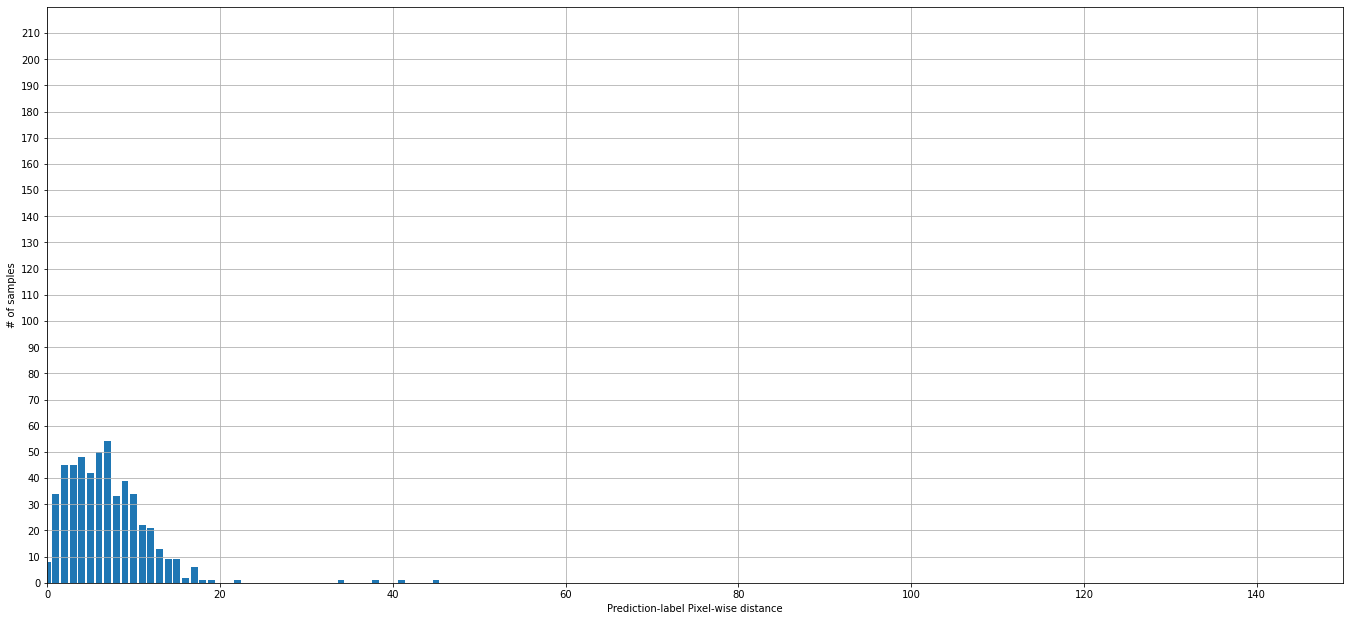

In [ ]:
# Plot the distance between prediction and labels for right_test_distance_pixel 
#TestDist = np.load("/content/drive/MyDrive/mahdie/results/TestDist1010.npy")

right_test_distance = TestDist

max_dist = max(right_test_distance)
cnt = numpy.zeros(round(max_dist))
for i in range(len(right_test_distance)):
  for j in range(round(max_dist)):
    if j <= right_test_distance[i] < j+1:
      cnt[j] += 1
    
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
a = numpy.arange(0,round(max_dist))
b = cnt

ax.set_xticks(numpy.arange(0, 150, 20))
ax.set_yticks(numpy.arange(0, 220, 10))
plt.xlabel('Prediction-label Pixel-wise distance')
plt.ylabel('# of samples')
ax.grid()
ax.bar(a,b)
plt.xlim([0, 150])
plt.ylim([0, 220])
plt.show()

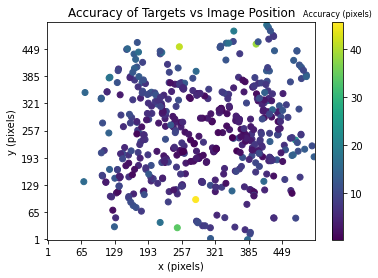

In [ ]:
test_y_global=[]
test_x_global=[]

for i in range(len(test_y)):

    x1_anc, x2_anc, y1_anc, y2_anc = anc_x_y[np.argmax(test_y, axis=1)[i]]
    x_cropped_cord = test_cropped_y_inversed[i][0]
    y_cropped_cord = test_cropped_y_inversed[i][1]
    test_x_global.append((x_cropped_cord/num_div_height + x1_anc)*512/224)
    test_y_global.append((y_cropped_cord/num_div_height + y1_anc)*512/224)

fig,ax=plt.subplots(1,1)
cp = ax.scatter(test_x_global[:], test_y_global[:], c=TestDist)
ax.set(xlim=(0, 512), xticks=np.arange(1, 512, 64),
       ylim=(0, 512), yticks=np.arange(1, 512, 64))

clb = fig.colorbar(cp)
clb.ax.set_title('Accuracy (pixels)',fontsize=8)
ax.set_title('Accuracy of Targets vs Image Position')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()